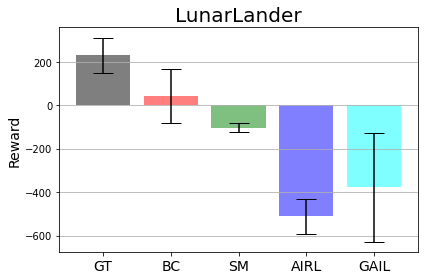

In [ ]:
# Create lists for the plot
materials = ['GT',  'BC', 'SM', 'AIRL', 'GAIL']
x_pos = np.arange(len(materials))
means = [229.04, 41.27, -102.60,  -511.83, -377.50]
error = [82.01, 124.65, 21.25,  82.06, 249.84]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, capsize=10, color=['black', 'red', 'green', 'blue', 'cyan'])
ax.set_ylabel('Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('LunarLander')
ax.yaxis.grid(True)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.label.set_fontsize(14)
ax.title.set_fontsize(20)


# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

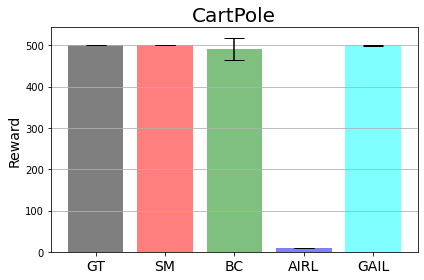

In [ ]:
# Create lists for the plot
materials = ['GT', 'SM', 'BC', 'AIRL', 'GAIL']
x_pos = np.arange(len(materials))
means = [500.00, 500.00, 490.91,  9.20, 499.80]
error = [0, 0.00, 26.83,  0.75, 0.60]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, capsize=10, color=['black', 'red', 'green', 'blue', 'cyan'])
ax.set_ylabel('Reward')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('CartPole')
ax.yaxis.grid(True)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.label.set_fontsize(14)
ax.title.set_fontsize(20)


# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# Setup

## Installation and Imports

In [ ]:
!apt install ffmpeg
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install gym[box2d]
!pip install imitation

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  freeglut3 freeglut3-dev xvfb
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 982 kB of archives.
After this operation, 3,350 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://arc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import itertools
import random
import pickle

%load_ext autoreload
%autoreload 2

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy

In [ ]:
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

In [ ]:
## enable rendering in Colab environment
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
%matplotlib inline
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
using_old_gym = True

## Visualization and Utilities


In [ ]:
import base64
import glob
import io
import os
from PIL import Image

def render_episodes(model):
  vec_env = model.get_env()
  obs = vec_env.reset()
  images = []
  for i in range(1000):
      action, _states = model.predict(obs, deterministic=True)
      obs, rewards, dones, info = vec_env.step(action)
      images.append(vec_env.render(mode="rgb_array"))
  os.system('rm -rf ./images/*.jpeg')
  for i, image in enumerate(images):
        im = Image.fromarray(image)
        im.save(f"images/{i:05d}.jpeg")
    
  os.system('ffmpeg -r 15 -i ./images/%05d.jpeg -vcodec mpeg4 -y -an  ep1.mp4')         

In [ ]:
## save and load trajectories for a faster run
import json

def trajs_to_json(trajs):
    new_trajs = []
    for traj in trajs:
        new_traj = []
        for component in traj:
            new_component = dict()
            for key in component.keys():
                if isinstance(component[key], np.ndarray):
                    new_component[key] = component[key].tolist()
                else:
                    new_component[key] = component[key]
            
            new_traj.append(new_component)
        new_trajs.append(new_traj)
    
    
    with open('trajs.json', 'w') as fout:
        json.dump(new_trajs, fout)

def trajs_from_json():
    with open("trajs.json", "r") as read_file:
        trajs = json.load(read_file)
    print(len(trajs))
    
    for traj in trajs:
        for component in traj:
            for key in component.keys():
                if isinstance(component[key], list):
                    component[key] = np.asarray(component[key], dtype=np.float32)
                
    return trajs



# Loss and Reward Network

## Score-matching Loss

In [ ]:
def score_matching_loss(transitions, reward_fn, device=None):
    loss = 0
    cur_states = []

    cur_state = torch.from_numpy(transitions.obs.copy())
    cur_state.requires_grad = True
    v = torch.randn_like(cur_state)

    if device is not None:
        cur_state = cur_state.to(device)
        v = v.to(device)
    reward = reward_fn(cur_state)

    # First term
    grad_state = torch.autograd.grad(reward.sum(), inputs=cur_state, create_graph=True)[0]
    loss_term_1 = (v * grad_state).sum(dim=-1).pow(2).mean()
    # loss_term_1 = (grad_state).pow(2).sum(dim=-1).mean()
    
    # Second term
    vector_hessian_prod = torch.autograd.functional.hvp(func=lambda x: reward_fn(x).sum(), inputs=cur_state, v=v, create_graph=True)[-1]
    loss_term_2 = (v * vector_hessian_prod).sum(dim=-1).mean()

    loss = loss_term_1 + loss_term_2 * 2    
    return loss


def trajs_to_tensor(trajs):
    cur_states = []
    for trajectory in trajs:
        for step in trajectory:
            cur_states.append(torch.from_numpy(step['cur_state']).unsqueeze(0))
    return torch.cat(cur_states, dim=0)

def old_score_matching_loss(trajs, reward_fn, noise_scale=0, noise_prob=0.05, device=None):
    cur_state = trajs_to_tensor(trajs)
    cur_state.requires_grad = True
    v = torch.randn_like(cur_state)
    
    if np.random.uniform() < noise_prob:
        cur_state = cur_state + torch.randn_like(cur_state) * noise_scale
    if device is not None:
        cur_state = cur_state.to(device)
        v = v.to(device)
    reward = reward_fn(cur_state)

    # First term
    grad_state = torch.autograd.grad(reward.sum(), inputs=cur_state, create_graph=True)[0]
    loss_term_1 = (v * grad_state).sum(dim=-1).pow(2).mean()
    # loss_term_1 = (grad_state).pow(2).sum(dim=-1).mean()
    
    # Second term
    vector_hessian_prod = torch.autograd.functional.hvp(func=lambda x: reward_fn(x).sum(), inputs=cur_state, v=v, create_graph=True)[-1]
    loss_term_2 = (v * vector_hessian_prod).sum(dim=-1).mean()
    
    #testing regularization
    loss_term_3 = 0.01 * torch.sum(reward**2)
    loss = loss_term_1 + loss_term_2 * 2 + loss_term_3   
    return loss_term_1 + loss_term_2 * 2, loss



In [ ]:
#@title
# experimental setup where reward is dependent not only on state but action too
class MlpQ(nn.Module):
    def __init__(self, input_dim, output_dim, hiddens=[32, 64]):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        prev_dim = self.input_dim
        layers = []
        for i, next_dim in enumerate(hiddens):
            layers.append(nn.Linear(prev_dim, next_dim))
            layers.append(nn.Tanh())
            prev_dim = next_dim
        layers.append(nn.Linear(prev_dim, self.output_dim))
        # layers.append(nn.Tanh())
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)


def trajs_to_tensor_2(trajs):
    cur_states = []
    cur_actions = []
    next_states = []
    next_actions = []
    for trajectory in trajs:
        for i, step in enumerate(trajectory[:-1]):
            cur_step = trajectory[i]
            next_step = trajectory[i+1]
            cur_states.append(torch.from_numpy(cur_step['cur_state']).unsqueeze(0))
            cur_actions.append(cur_step['action'])
            next_states.append(torch.from_numpy(next_step['cur_state']).unsqueeze(0))
            next_actions.append(next_step['action'])
            
    cur_actions = torch.LongTensor(cur_actions)
    next_actions = torch.LongTensor(next_actions)
    
    return torch.cat(cur_states, dim=0), cur_actions, torch.cat(next_states, dim=0), next_actions

def secondary_loss(my_reward, my_q, trajs, gamma=0.9, device=None):
    cur_states, cur_actions, next_states, next_actions = trajs_to_tensor_2(trajs)
    cur_actions = cur_actions.long()
    next_actions = next_actions.long()
    if device is not None:
        cur_states = cur_states.to(device)
        cur_actions = cur_actions.to(device)
        next_states = next_states.to(device)
        next_actions = next_actions.to(device)

    cur_q = my_q(cur_states)
    next_q = my_q(next_states)
    cur_r = my_reward(cur_states)
    next_r = my_reward(next_states)

    # Q loss
    q_loss = (torch.index_select(cur_q, 1, cur_actions) - (next_r + gamma * next_q.max(dim=1, keepdim=True)[0]).detach()).pow(2).mean()

    # Reward loss
    r_loss = (next_r - (torch.index_select(cur_q, 1, cur_actions) - gamma * torch.index_select(next_q, 1, next_actions)).detach()).pow(2).mean()

    return q_loss, r_loss

## Reward Network

In [ ]:
class MlpReward(nn.Module):
    def __init__(self, input_dim, hiddens=[32, 64], last_activation="sigmoid"):
        super().__init__()
        self.input_dim = input_dim

        prev_dim = self.input_dim
        layers = []
        for i, next_dim in enumerate(hiddens):
            layers.append(nn.Linear(prev_dim, next_dim))
            layers.append(nn.Softplus())
            prev_dim = next_dim
        layers.append(nn.Linear(prev_dim, 1))
        if last_activation == "sigmoid":
          layers.append(nn.Sigmoid())
        elif last_activation == "tanh":
          layers.append(nn.Tanh())
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)

# Generating Expert Trajectories

In [ ]:
# Uses the imitation library to generate expert trajectories
def generate_expert_trajectories(expert, env, num_trajectories=500, max_length=200):
    rollouts = rollout.rollout(
        expert,
        DummyVecEnv([lambda: RolloutInfoWrapper(env)]),
        rollout.make_sample_until(min_timesteps=max_length, min_episodes=num_trajectories),
        rng=np.random.default_rng(),
    )
    return rollouts

In [ ]:
# Our own code for generating expert trajectories
def old_generate_expert_trajectories(expert, env, num_trajectories=100, max_length=20, deterministic=True):
    trajectories = []
    for i in range(num_trajectories):
        episode = []
        obs = env.reset()
        for j in range(max_length):
            action, _states = expert.predict(obs, deterministic=deterministic)

            if using_old_gym:
                next_obs, reward, done, info = env.step(action)
            else:
                next_obs, reward, terminate, truncate, info = env.step(action)
                done = (terminate or truncate)
            episode.append({'cur_state': obs, 'action': action, 'next_state': next_obs, 'reward': reward, 'done': done})
            obs = next_obs
                        
            if done:
                break
        trajectories.append(episode)
        
    return trajectories

## CartPole Expert

In [ ]:
cp_env = gym.make("CartPole-v1")
cp_expert = PPO(
    policy=MlpPolicy,
    env=cp_env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)

# Use a separate environement for evaluation
cp_eval_env = gym.make('CartPole-v1')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(cp_expert, cp_eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:351.96 +/- 197.61


In [ ]:
cp_expert.learn(1e5)  # Note: set to 10000 to train a proficient expert

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(cp_expert, cp_eval_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:500.00 +/- 0.00


In [ ]:
# Trajectories generated by our own code
cp_trajs = old_generate_expert_trajectories(cp_expert, cp_env, num_trajectories=500, max_length=200, deterministic=False)

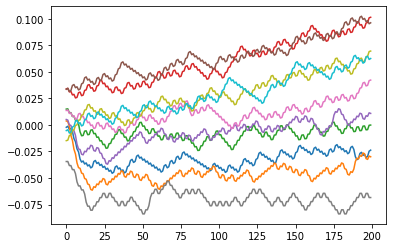

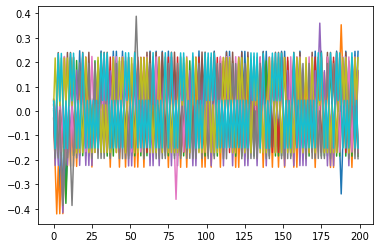

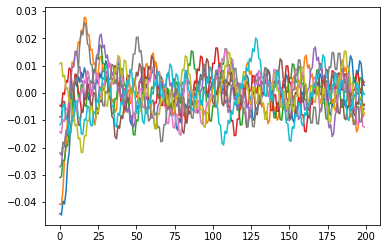

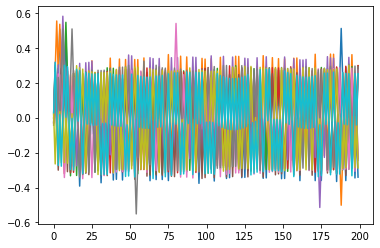

In [ ]:
# Sanity check. Trajectories are different
for i in range(10):
    plt.plot([x['cur_state'][0] for x in cp_trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][1] for x in cp_trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][2] for x in cp_trajs[i]])
plt.show()

for i in range(10):
    plt.plot([x['cur_state'][3] for x in cp_trajs[i]])
plt.show()


In [ ]:
my_file = open('cp_trajs', 'wb')
pickle.dump(cp_trajs, my_file)
my_file.close()

In [ ]:
my_file = open('cp_trajs', 'rb')
cp_trajs = pickle.load(my_file)
my_file.close()

In [ ]:
# Trajectories from the imitation library
cp_rollouts = generate_expert_trajectories(cp_expert, cp_env, num_trajectories=500, max_length=200)

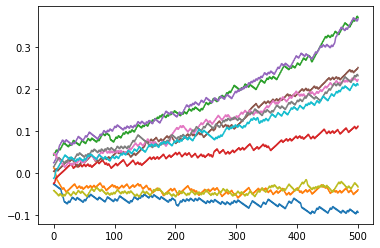

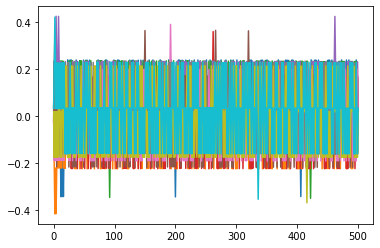

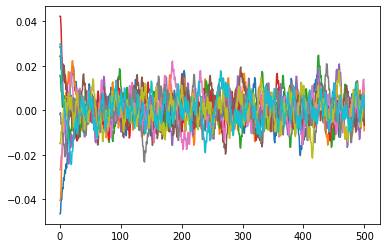

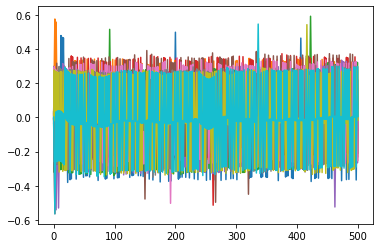

In [ ]:
# Sanity check. Trajectories are different
for i in range(4):
    for j in range(10):
        plt.plot(cp_rollouts[j].obs[:,i])
    plt.show()

In [ ]:
my_file = open('cp_rollouts', 'wb')
pickle.dump(cp_rollouts, my_file)
my_file.close()

In [ ]:
my_file = open('cp_rollouts', 'rb')
cp_rollouts = pickle.load(my_file)
my_file.close()

## LunarLander Expert

In [ ]:
ll_env = gym.make('LunarLander-v2')
ll_expert = DQN('MlpPolicy', 'LunarLander-v2', verbose=0, exploration_final_eps=0.1, target_update_interval=250)
# Separate env for evaluation
ll_eval_env = gym.make('LunarLander-v2')

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(ll_expert, ll_eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

# Train the agent
ll_expert.learn(total_timesteps=int(5e5))
# Save the agent
ll_expert.save("dqn_lunar")
# # Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(ll_expert, ll_eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=-824.22 +/- 407.1045765072939
mean_reward=229.04 +/- 82.01274399259374


In [ ]:
# Load a pretrained expert
ll_env = gym.make('LunarLander-v2')
ll_expert = DQN.load("dqn_lunar", env=ll_env)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(ll_expert, ll_eval_env, n_eval_episodes=20)

print(f"After learning mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

After learning mean_reward:221.78 +/- 82.23


In [ ]:
ll_trajs = old_generate_expert_trajectories(ll_expert, ll_env, num_trajectories=100, max_length=1000, deterministic=False)
trajs_to_json(ll_trajs)

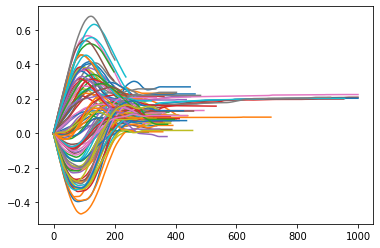

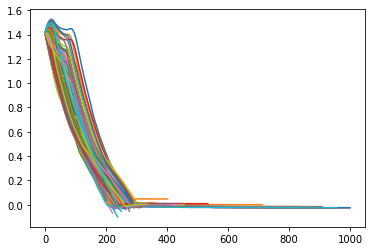

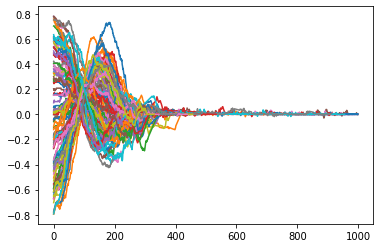

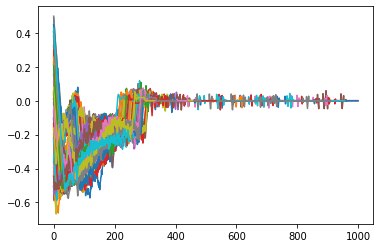

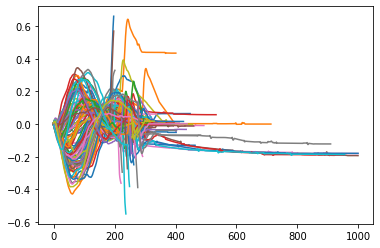

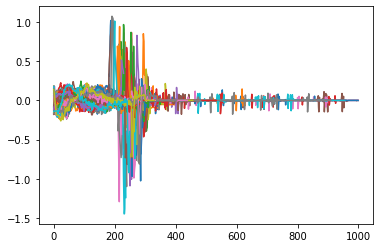

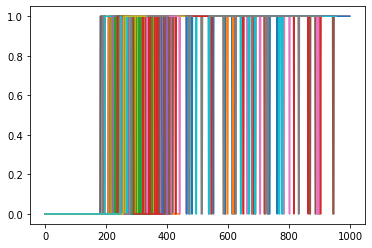

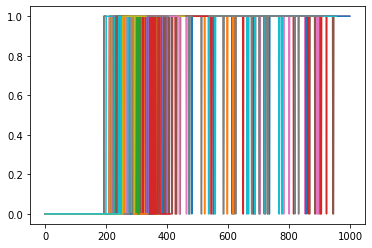

In [ ]:
for j in range(8):
  for i in range(100):
      plt.plot([x['cur_state'][j] for x in ll_trajs[i]])
  plt.show()

In [ ]:
#load trajectories instead of generating them, if saved before
ll_trajs = trajs_from_json()

100


In [ ]:
ll_rollouts = generate_expert_trajectories(ll_expert, ll_env, num_trajectories=100, max_length=1000)

In [ ]:
myf = open('ll_rollouts', 'wb')
pickle.dump(ll_rollouts, myf)
myf.close()

In [ ]:
myf = open('ll_rollouts', 'rb')
ll_rollouts = pickle.load(myf)
myf.close()

# CartPole Environment

## Training Reward Function

---



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
my_reward = MlpReward(cp_env.observation_space.shape[0], hiddens=[32, 32, 32]).to(device)

optimizer = torch.optim.Adam(
    my_reward.parameters(),
    lr=1e-3, betas=(0.9, 0.99)
)

In [ ]:
## Training using the new loss function with trajectories from the imitation package
epochs = 100
batch_size = 32 * 300

for epoch in range(epochs):
    random.shuffle(cp_rollouts)
    transitions = rollout.flatten_trajectories_with_rew(cp_rollouts)
    for i in range(0, len(transitions), batch_size):
        batch = transitions[i : min(i + batch_size, len(transitions))]

        optimizer.zero_grad()
        loss = score_matching_loss(batch, my_reward, device)
        loss.backward()
        optimizer.step()
    print(epoch, ":", loss)    


In [ ]:
## Training using the old loss function with our generated trajectories
epochs = 100
batch_size = 32

for epoch in range(epochs):
    random.shuffle(cp_trajs)
    for i in range(0, len(cp_trajs), batch_size):
        batch = cp_trajs[i : min(i + batch_size, len(cp_trajs))]

        optimizer.zero_grad()
        loss = old_score_matching_loss(batch, my_reward, device=device)[0]
        loss.backward()
        optimizer.step()
    print(epoch, ":", loss)    


0 : tensor(-0.0150, device='cuda:0', grad_fn=<AddBackward0>)
1 : tensor(-0.0503, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(-0.1237, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(-0.2688, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(-0.5748, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(-1.2096, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(-2.4683, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(-4.4668, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(-9.8774, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(-21.2138, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(-40.7955, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(-66.8324, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(-96.2149, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(-122.5873, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(-161.6737, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(-190.8176, device='cuda:0', grad_fn=<AddBackward0>)
16 : ten

## Visualizing the learned reward

In [ ]:
my_reward = my_reward.to('cpu')

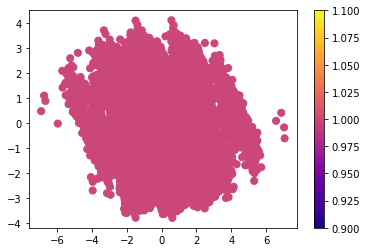

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

all_states = [cp_trajs[i][j]['cur_state'].tolist() for i in range(len(cp_trajs))  for j in range(len(cp_trajs[i]))]
all_rewards = [0 if cp_trajs[i][j]['done'] else 1 for i in range(len(cp_trajs))  for j in range(len(cp_trajs[i]))]

x = StandardScaler().fit_transform(np.array(all_states))
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)
x_2d.shape

f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=all_rewards, s=50, cmap="plasma")
f.colorbar(points)


plt.show()

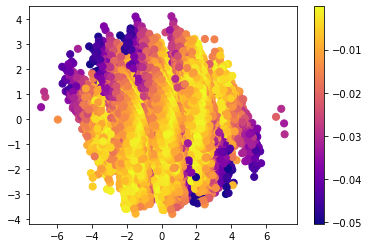

In [ ]:
angles = (-abs(np.array(all_states)[:,2])).tolist()
f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=angles, s=50, cmap="plasma")
f.colorbar(points)

plt.show()

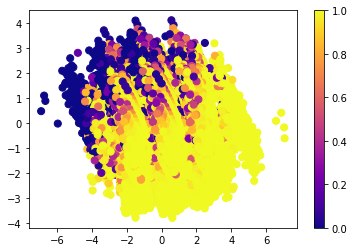

In [ ]:
pred_rewards_all = my_reward(torch.tensor(all_states))
pra = pred_rewards_all.clone().detach().cpu().numpy()[:,0].tolist()
f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=pra, s=50, cmap="plasma")
f.colorbar(points)

plt.show()

## Test Learnt Reward on PPO Policy

In [ ]:
class MyEnv(gym.envs.classic_control.CartPoleEnv):
    def __init__(self, *args, **kwargs):
        my_reward = kwargs.pop('my_reward')
        super().__init__(*args, **kwargs)
        self.my_reward = my_reward
    
    def step(self, action):
        if using_old_gym:
            next_obs, reward, done, info = super().step(action)
        else:
            next_obs, reward, terminate, truncate, info = super().step(action)
        reward = self.my_reward(torch.from_numpy(next_obs).unsqueeze(0)).clone().detach().cpu().numpy().item()
        if using_old_gym:
            return next_obs, reward, done, info
        else:
            return next_obs, reward, terminate, truncate, info

In [ ]:
custom_reward_env = MyEnv(my_reward=my_reward)
cp_agent = PPO(
    policy=MlpPolicy,
    env=custom_reward_env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)

In [ ]:
# The agent at initialization
mean_reward, std_reward = evaluate_policy(cp_agent, cp_eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:458.95 +/- 123.15


In [ ]:
cp_agent.learn(50_000)

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(cp_agent, cp_eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:338.00 +/- 30.74


In [ ]:
#saves video of episode into ep1.mp4
render_episodes(cp_agent)

# LunarLander Environment

## Training Reward Function

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
my_reward = MlpReward(ll_env.observation_space.shape[0], hiddens=[32, 32, 32], last_activation='tanh').to(device)
# my_q = MlpQ(env.observation_space.shape[0], 4, hiddens=[64, 64]).to(device)

optimizer = torch.optim.Adam(
    [
        {'params': my_reward.parameters(), 'weight_decay': 1e-4},
        # {'params': my_q.parameters()},
    ],
    lr=5e-3, betas=(0.9, 0.99)
)

epochs = 100
batch_size = 8
done = False
for epoch in range(epochs):
    random.shuffle(ll_trajs)
    for i in range(0, len(ll_trajs), batch_size):
        batch = ll_trajs[i : min(i + batch_size, len(ll_trajs))]

        optimizer.zero_grad()
        loss1, score_loss = old_score_matching_loss(batch, my_reward, noise_scale=0.1, noise_prob=1, device=device)
        # q_loss, r_loss = secondary_loss(my_reward, my_q, batch, device=device)

        loss =  score_loss
        loss.backward()
        optimizer.step()
    print(epoch, ":", loss.item(), loss1.item())    


0 : -0.004301553592085838 -0.020748544484376907
1 : -0.034801412373781204 -0.0382104218006134
2 : -0.07723858952522278 -0.07769309729337692
3 : -0.18681035935878754 -0.18947447836399078
4 : -0.5734062194824219 -0.5782428979873657
5 : -2.550675630569458 -2.6310315132141113
6 : -9.424551963806152 -9.791654586791992
7 : -17.387969970703125 -18.74152183532715
8 : -28.382482528686523 -29.721162796020508
9 : -37.62787628173828 -39.17037582397461
10 : -48.885032653808594 -50.8929557800293
11 : -42.989585876464844 -50.54216003417969
12 : -49.320613861083984 -56.04120635986328
13 : -79.74325561523438 -83.26099395751953
14 : -80.20417022705078 -86.55461120605469
15 : -55.81804275512695 -65.24118041992188
16 : -93.4751205444336 -96.92231750488281
17 : -93.48149871826172 -99.02708435058594
18 : -116.48017883300781 -120.08988952636719
19 : -99.41568756103516 -105.02987670898438
20 : -116.61688995361328 -121.03860473632812
21 : -105.18089294433594 -109.98521423339844
22 : -113.0967788696289 -117.727

In [ ]:
torch.save(my_reward.state_dict(), 'll_sm_reward.zip')

## Test Learnt Reward on DQN Policy

In [ ]:
class MyEnv(gym.envs.box2d.LunarLander):
    def __init__(self, *args, **kwargs):
        my_reward = kwargs.pop('my_reward')
        super().__init__(*args, **kwargs)
        self.my_reward = my_reward
    
    def step(self, action):
        if using_old_gym:
            next_obs, reward, done, info = super().step(action)
        else:
            next_obs, reward, terminate, truncate, info = super().step(action)
        reward = self.my_reward(torch.from_numpy(next_obs).unsqueeze(0)).clone().detach().cpu().numpy().item()
        if using_old_gym:
            return next_obs, reward, done, info
        else:
            return next_obs, reward, terminate, truncate, info

In [ ]:
my_reward = my_reward.to('cpu')

In [ ]:
custom_reward_env = MyEnv(my_reward=my_reward)
ll_agent = DQN('MlpPolicy', custom_reward_env, learning_rate=1e-4, verbose=0, exploration_final_eps=0.1, target_update_interval=250)
# expert = DQN('MlpPolicy', custom_reward_env, learning_rate=1e-3, verbose=2)

In [ ]:
mean_reward, std_reward = evaluate_policy(ll_agent, ll_eval_env, n_eval_episodes=20)

print(f"Before score matching mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Before score matching mean_reward:-627.29 +/- 180.52


In [ ]:
ll_agent.learn(total_timesteps=int(1e5))

In [ ]:
ll_agent.save("dqn_lunar_sm")

In [ ]:
ll_agent = DQN.load("dqn_lunar_sm", env=ll_eval_env)

In [ ]:
mean_reward, std_reward = evaluate_policy(ll_agent, ll_eval_env, n_eval_episodes=20)

print(f"After score matching mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

After score matching mean_reward:-102.60 +/- 21.25


In [ ]:
#save video of episode in ep1.mp4
render_episodes(ll_agent)

## Visualizing the learnt reward

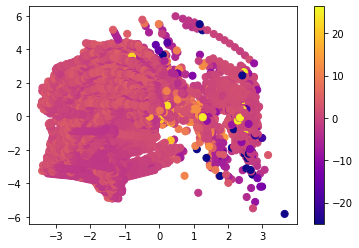

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

all_states = [ll_trajs[i][j]['cur_state'].tolist() for i in range(len(ll_trajs))  for j in range(len(ll_trajs[i]))]
all_rewards = [ll_trajs[i][j]['reward'] if abs(ll_trajs[i][j]['reward']) <100 else ll_trajs[i][j]['reward']/100 *25  for i in range(len(ll_trajs))  for j in range(len(ll_trajs[i]))]

x = StandardScaler().fit_transform(np.array(all_states))
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)
x_2d.shape

f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=all_rewards, s=50, cmap="plasma")
f.colorbar(points)
plt.savefig('ll_gt_rewards.png')

plt.show()

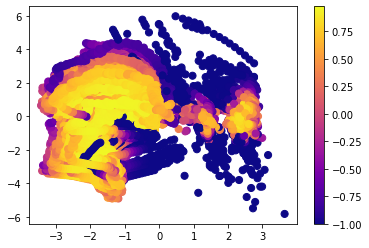

In [ ]:
pred_rewards_all = my_reward(torch.tensor(all_states))
pra = pred_rewards_all.clone().detach().cpu().numpy()[:,0].tolist()
f, ax = plt.subplots()
points = ax.scatter(x_2d[:, 0], x_2d[:,1], c=pra, s=50, cmap="plasma")
f.colorbar(points)
plt.savefig('ll_sm_rewards.png')

plt.show()

# Baselines

## Behavioral Cloning

### CartPole

In [ ]:
bc_trainer = bc.BC(
    observation_space=cp_env.observation_space,
    action_space=cp_env.action_space,
    demonstrations=cp_rollouts,
    rng=np.random.default_rng(),
)
bc_trainer.train(n_epochs=1)

mean_reward, std_reward = evaluate_policy(bc_trainer.policy, cp_eval_env, 10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 36.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


491batch [00:02, 208.45batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00025 |
|    entropy        | 0.25     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 56.7     |
|    loss           | 0.174    |
|    neglogp        | 0.175    |
|    prob_true_act  | 0.872    |
|    samples_so_far | 16032    |
--------------------------------


987batch [00:04, 220.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000288 |
|    entropy        | 0.288     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 85.5      |
|    loss           | 0.316     |
|    neglogp        | 0.317     |
|    prob_true_act  | 0.791     |
|    samples_so_far | 32032     |
---------------------------------


1479batch [00:08, 212.84batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -0.000229 |
|    entropy        | 0.229     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 115       |
|    loss           | 0.438     |
|    neglogp        | 0.438     |
|    prob_true_act  | 0.804     |
|    samples_so_far | 48032     |
---------------------------------


1979batch [00:10, 221.66batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2000      |
|    ent_loss       | -0.000189 |
|    entropy        | 0.189     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 120       |
|    loss           | 0.289     |
|    neglogp        | 0.289     |
|    prob_true_act  | 0.844     |
|    samples_so_far | 64032     |
---------------------------------


2484batch [00:12, 224.98batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 2500      |
|    ent_loss       | -0.000316 |
|    entropy        | 0.316     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 123       |
|    loss           | 0.323     |
|    neglogp        | 0.324     |
|    prob_true_act  | 0.779     |
|    samples_so_far | 80032     |
---------------------------------


2995batch [00:14, 221.25batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3000      |
|    ent_loss       | -0.000257 |
|    entropy        | 0.257     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 124       |
|    loss           | 0.289     |
|    neglogp        | 0.289     |
|    prob_true_act  | 0.809     |
|    samples_so_far | 96032     |
---------------------------------


3481batch [00:17, 229.71batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 3500      |
|    ent_loss       | -0.000282 |
|    entropy        | 0.282     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 126       |
|    loss           | 0.34      |
|    neglogp        | 0.341     |
|    prob_true_act  | 0.799     |
|    samples_so_far | 112032    |
---------------------------------


3985batch [00:19, 226.29batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 4000      |
|    ent_loss       | -0.000303 |
|    entropy        | 0.303     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 125       |
|    loss           | 0.272     |
|    neglogp        | 0.272     |
|    prob_true_act  | 0.81      |
|    samples_so_far | 128032    |
---------------------------------


4494batch [00:21, 217.08batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 4500     |
|    ent_loss       | -0.00022 |
|    entropy        | 0.22     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 126      |
|    loss           | 0.334    |
|    neglogp        | 0.334    |
|    prob_true_act  | 0.86     |
|    samples_so_far | 144032   |
--------------------------------


5000batch [00:24, 226.73batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 5000      |
|    ent_loss       | -0.000185 |
|    entropy        | 0.185     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 128       |
|    loss           | 0.124     |
|    neglogp        | 0.124     |
|    prob_true_act  | 0.903     |
|    samples_so_far | 160032    |
---------------------------------


5488batch [00:26, 221.39batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 5500      |
|    ent_loss       | -0.000274 |
|    entropy        | 0.274     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 127       |
|    loss           | 0.328     |
|    neglogp        | 0.329     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 176032    |
---------------------------------


6000batch [00:29, 158.32batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 6000      |
|    ent_loss       | -0.000277 |
|    entropy        | 0.277     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 129       |
|    loss           | 0.312     |
|    neglogp        | 0.313     |
|    prob_true_act  | 0.798     |
|    samples_so_far | 192032    |
---------------------------------


6483batch [00:32, 148.15batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 6500      |
|    ent_loss       | -0.000239 |
|    entropy        | 0.239     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 129       |
|    loss           | 0.283     |
|    neglogp        | 0.283     |
|    prob_true_act  | 0.829     |
|    samples_so_far | 208032    |
---------------------------------


6979batch [00:34, 224.52batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 7000      |
|    ent_loss       | -0.000352 |
|    entropy        | 0.352     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 130       |
|    loss           | 0.493     |
|    neglogp        | 0.494     |
|    prob_true_act  | 0.719     |
|    samples_so_far | 224032    |
---------------------------------


7492batch [00:36, 221.05batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 7500      |
|    ent_loss       | -0.000238 |
|    entropy        | 0.238     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 131       |
|    loss           | 0.301     |
|    neglogp        | 0.301     |
|    prob_true_act  | 0.818     |
|    samples_so_far | 240032    |
---------------------------------


7809batch [00:38, 221.15batch/s]
7812batch [00:38, 203.38batch/s]
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:500.00 +/- 0.00


### LunarLander

In [ ]:
bc_trainer = bc.BC(
    observation_space=ll_env.observation_space,
    action_space=ll_env.action_space,
    demonstrations=ll_rollouts,
    rng=np.random.default_rng(),
)
bc_trainer.train(n_epochs=1)

mean_reward, std_reward = evaluate_policy(bc_trainer.policy, ll_eval_env, 10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 40.5     |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.25     |
|    samples_so_far | 32       |
--------------------------------


493batch [00:02, 215.73batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | -0.00107 |
|    entropy        | 1.07     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 53       |
|    loss           | 1.03     |
|    neglogp        | 1.03     |
|    prob_true_act  | 0.427    |
|    samples_so_far | 16032    |
--------------------------------


992batch [00:04, 216.26batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -0.00104 |
|    entropy        | 1.04     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 70.9     |
|    loss           | 0.885    |
|    neglogp        | 0.886    |
|    prob_true_act  | 0.484    |
|    samples_so_far | 32032    |
--------------------------------


1263batch [00:05, 219.46batch/s]
1277batch [00:05, 215.73batch/s]
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:41.27 +/- 124.65


## Adversarial IRL

In [ ]:
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm

### CartPole

In [ ]:
# import seals

# from imitation.util.util import make_vec_env


venv = DummyVecEnv([lambda: RolloutInfoWrapper(cp_env)])
# venv = make_vec_env("seals/CartPole-v0", rng=np.random.default_rng(), n_envs=8)

# venv = DummyVecEnv([lambda: RolloutInfoWrapper(env)])
learner = PPO(env=venv, policy=MlpPolicy)
reward_net = BasicShapedRewardNet(
    venv.observation_space,
    venv.action_space,
    normalize_input_layer=RunningNorm,
)

airl_trainer = AIRL(
    demonstrations=cp_rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

airl_trainer.train(20000)

mean_reward, std_reward = evaluate_policy(airl_trainer.policy, cp_eval_env, 10)
print()
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


round:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 424  |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 4    |
|    gen/time/total_timesteps | 2048 |
--------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.612    |
|    disc/disc_loss                   | 0.787    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
--------------------------------------------------
--------------------------------------------------
| raw/       

round:  11%|█         | 1/9 [00:06<00:52,  6.56s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | 3.69       |
|    gen/time/fps                    | 427        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 4096       |
|    gen/train/approx_kl             | 0.02025777 |
|    gen/train/clip_fraction         | 0.301      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.679     |
|    gen/train/explained_variance    | 0.128      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.48       |
|    gen/train/n_updates             | 10         |
|    gen/train/policy_gradient_loss  | -0.0434    |
|    gen/train/value_loss            | 1.42       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  22%|██▏       | 2/9 [00:13<00:45,  6.53s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 4.05        |
|    gen/time/fps                    | 422         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 6144        |
|    gen/train/approx_kl             | 0.023051217 |
|    gen/train/clip_fraction         | 0.291       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.624      |
|    gen/train/explained_variance    | 0.192       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.49        |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.0289     |
|    gen/train/value_loss            | 2.65        |
----------------------------------------------------
----------------------------------------------

round:  33%|███▎      | 3/9 [00:19<00:39,  6.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 2.72        |
|    gen/time/fps                    | 328         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 6           |
|    gen/time/total_timesteps        | 8192        |
|    gen/train/approx_kl             | 0.013564337 |
|    gen/train/clip_fraction         | 0.236       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.554      |
|    gen/train/explained_variance    | 0.535       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.254       |
|    gen/train/n_updates             | 30          |
|    gen/train/policy_gradient_loss  | -0.023      |
|    gen/train/value_loss            | 0.726       |
----------------------------------------------------
----------------------------------------------

round:  44%|████▍     | 4/9 [00:27<00:35,  7.10s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 1.82        |
|    gen/time/fps                    | 427         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 10240       |
|    gen/train/approx_kl             | 0.050428025 |
|    gen/train/clip_fraction         | 0.343       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.406      |
|    gen/train/explained_variance    | 0.699       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0166      |
|    gen/train/n_updates             | 40          |
|    gen/train/policy_gradient_loss  | -0.0503     |
|    gen/train/value_loss            | 0.188       |
----------------------------------------------------
----------------------------------------------

round:  56%|█████▌    | 5/9 [00:34<00:27,  6.89s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 1.55        |
|    gen/time/fps                    | 425         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 12288       |
|    gen/train/approx_kl             | 0.071268275 |
|    gen/train/clip_fraction         | 0.102       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.214      |
|    gen/train/explained_variance    | 0.791       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.0251      |
|    gen/train/n_updates             | 50          |
|    gen/train/policy_gradient_loss  | -0.032      |
|    gen/train/value_loss            | 0.108       |
----------------------------------------------------
----------------------------------------------

round:  67%|██████▋   | 6/9 [00:40<00:20,  6.76s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 0.841       |
|    gen/time/fps                    | 432         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 14336       |
|    gen/train/approx_kl             | 0.003913484 |
|    gen/train/clip_fraction         | 0.0537      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.147      |
|    gen/train/explained_variance    | 0.539       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.105       |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.0173     |
|    gen/train/value_loss            | 0.185       |
----------------------------------------------------
----------------------------------------------

round:  78%|███████▊  | 7/9 [00:47<00:13,  6.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | 0.251        |
|    gen/time/fps                    | 424          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 16384        |
|    gen/train/approx_kl             | 0.0019553066 |
|    gen/train/clip_fraction         | 0.0333       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.116       |
|    gen/train/explained_variance    | 0.714        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | -0.00222     |
|    gen/train/n_updates             | 70           |
|    gen/train/policy_gradient_loss  | -0.00937     |
|    gen/train/value_loss            | 0.044        |
-----------------------------------------------------
----------------------------

round:  89%|████████▉ | 8/9 [00:53<00:06,  6.62s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -0.534       |
|    gen/time/fps                    | 428          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 18432        |
|    gen/train/approx_kl             | 0.0009787865 |
|    gen/train/clip_fraction         | 0.0189       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.0864      |
|    gen/train/explained_variance    | 0.442        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 0.026        |
|    gen/train/n_updates             | 80           |
|    gen/train/policy_gradient_loss  | -0.00654     |
|    gen/train/value_loss            | 0.0563       |
-----------------------------------------------------
----------------------------

round: 100%|██████████| 9/9 [01:00<00:00,  6.68s/it]


mean_reward:9.60 +/- 0.80


### LunarLander

In [ ]:
venv = DummyVecEnv([lambda: RolloutInfoWrapper(ll_env)])
learner = PPO(env=venv, policy=MlpPolicy)
reward_net = BasicShapedRewardNet(
    venv.observation_space,
    venv.action_space,
    normalize_input_layer=RunningNorm,
)

airl_trainer = AIRL(
    demonstrations=ll_rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

airl_trainer.train(20000)
mean_reward, std_reward = evaluate_policy(airl_trainer.policy, ll_eval_env, 10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


round:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 391  |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 5    |
|    gen/time/total_timesteps | 2048 |
--------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.483    |
|    disc/disc_loss                   | 0.941    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
--------------------------------------------------
--------------------------------------------------
| raw/       

round:  11%|█         | 1/9 [00:06<00:55,  6.99s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 3.03        |
|    gen/time/fps                    | 396         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 4096        |
|    gen/train/approx_kl             | 0.013469081 |
|    gen/train/clip_fraction         | 0.19        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -1.38       |
|    gen/train/explained_variance    | -0.0709     |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.123       |
|    gen/train/n_updates             | 10          |
|    gen/train/policy_gradient_loss  | -0.0159     |
|    gen/train/value_loss            | 0.273       |
----------------------------------------------------
----------------------------------------------

round:  22%|██▏       | 2/9 [00:13<00:48,  6.97s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 2.77        |
|    gen/time/fps                    | 391         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 6144        |
|    gen/train/approx_kl             | 0.015629726 |
|    gen/train/clip_fraction         | 0.258       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -1.33       |
|    gen/train/explained_variance    | 0.27        |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.448       |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.0197     |
|    gen/train/value_loss            | 1.87        |
----------------------------------------------------
----------------------------------------------

round:  33%|███▎      | 3/9 [00:20<00:41,  6.97s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 1.67        |
|    gen/time/fps                    | 392         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 8192        |
|    gen/train/approx_kl             | 0.015812857 |
|    gen/train/clip_fraction         | 0.365       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -1.25       |
|    gen/train/explained_variance    | 0.487       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.918       |
|    gen/train/n_updates             | 30          |
|    gen/train/policy_gradient_loss  | -0.0332     |
|    gen/train/value_loss            | 1.91        |
----------------------------------------------------
----------------------------------------------

round:  44%|████▍     | 4/9 [00:27<00:34,  6.95s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 0.32        |
|    gen/time/fps                    | 395         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 10240       |
|    gen/train/approx_kl             | 0.018996324 |
|    gen/train/clip_fraction         | 0.372       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -1.15       |
|    gen/train/explained_variance    | 0.597       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.656       |
|    gen/train/n_updates             | 40          |
|    gen/train/policy_gradient_loss  | -0.0273     |
|    gen/train/value_loss            | 1.75        |
----------------------------------------------------
----------------------------------------------

round:  56%|█████▌    | 5/9 [00:34<00:27,  6.93s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -2.86       |
|    gen/time/fps                    | 392         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 12288       |
|    gen/train/approx_kl             | 0.021133877 |
|    gen/train/clip_fraction         | 0.245       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -1.01       |
|    gen/train/explained_variance    | 0.718       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.225       |
|    gen/train/n_updates             | 50          |
|    gen/train/policy_gradient_loss  | -0.0275     |
|    gen/train/value_loss            | 1.07        |
----------------------------------------------------
----------------------------------------------

round:  67%|██████▋   | 6/9 [00:41<00:20,  6.95s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -6.91      |
|    gen/time/fps                    | 394        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 5          |
|    gen/time/total_timesteps        | 14336      |
|    gen/train/approx_kl             | 0.01629219 |
|    gen/train/clip_fraction         | 0.188      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.865     |
|    gen/train/explained_variance    | 0.787      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.156      |
|    gen/train/n_updates             | 60         |
|    gen/train/policy_gradient_loss  | -0.0185    |
|    gen/train/value_loss            | 0.845      |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  78%|███████▊  | 7/9 [00:48<00:13,  6.93s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -11.8       |
|    gen/time/fps                    | 394         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 16384       |
|    gen/train/approx_kl             | 0.013338145 |
|    gen/train/clip_fraction         | 0.136       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.785      |
|    gen/train/explained_variance    | 0.821       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.104       |
|    gen/train/n_updates             | 70          |
|    gen/train/policy_gradient_loss  | -0.0134     |
|    gen/train/value_loss            | 0.854       |
----------------------------------------------------
----------------------------------------------

round:  89%|████████▉ | 8/9 [00:55<00:06,  6.93s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_rew_wrapped_mean | -17.4     |
|    gen/time/fps                    | 398       |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 5         |
|    gen/time/total_timesteps        | 18432     |
|    gen/train/approx_kl             | 0.0114472 |
|    gen/train/clip_fraction         | 0.0786    |
|    gen/train/clip_range            | 0.2       |
|    gen/train/entropy_loss          | -0.684    |
|    gen/train/explained_variance    | 0.854     |
|    gen/train/learning_rate         | 0.0003    |
|    gen/train/loss                  | 0.123     |
|    gen/train/n_updates             | 80        |
|    gen/train/policy_gradient_loss  | -0.00867  |
|    gen/train/value_loss            | 1.07      |
--------------------------------------------------
--------------------------------------------------
| raw/                         

round: 100%|██████████| 9/9 [01:02<00:00,  6.93s/it]


mean_reward:-511.83 +/- 82.06


## GAIL

### CartPole

In [ ]:
from imitation.algorithms.adversarial.gail import GAIL

venv = DummyVecEnv([lambda: RolloutInfoWrapper(cp_env)])
# venv = make_vec_env("seals/CartPole-v0", rng=np.random.default_rng(), n_envs=8)

# venv = DummyVecEnv([lambda: RolloutInfoWrapper(env)])
learner = PPO(env=venv, policy=MlpPolicy)
reward_net = BasicShapedRewardNet(
    venv.observation_space,
    venv.action_space,
    normalize_input_layer=RunningNorm,
)

gail_trainer = GAIL(
    demonstrations=cp_rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

gail_trainer.train(20000)

mean_reward, std_reward = evaluate_policy(gail_trainer.policy, cp_eval_env, 10)
print()
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


round:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 416  |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 4    |
|    gen/time/total_timesteps | 2048 |
--------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.461    |
|    disc/disc_acc_expert             | 0.246    |
|    disc/disc_acc_gen                | 0.676    |
|    disc/disc_entropy                | 0.685    |
|    disc/disc_loss                   | 0.684    |
|    disc/disc_proportion_expert_pred | 0.285    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 1.02e+03 |
|    disc/n_generated                 | 1.02e+03 |
--------------------------------------------------
--------------------------------------------------
| raw/       

round:  11%|█         | 1/9 [00:06<00:53,  6.63s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 15.4        |
|    gen/time/fps                    | 386         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 4096        |
|    gen/train/approx_kl             | 0.010919673 |
|    gen/train/clip_fraction         | 0.138       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.685      |
|    gen/train/explained_variance    | -0.00596    |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 2.45        |
|    gen/train/n_updates             | 10          |
|    gen/train/policy_gradient_loss  | -0.0202     |
|    gen/train/value_loss            | 23.6        |
----------------------------------------------------
----------------------------------------------

round:  22%|██▏       | 2/9 [00:13<00:48,  6.87s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 17.8        |
|    gen/time/fps                    | 416         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 6144        |
|    gen/train/approx_kl             | 0.010334833 |
|    gen/train/clip_fraction         | 0.0936      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.658      |
|    gen/train/explained_variance    | 0.155       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 6.11        |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.0225     |
|    gen/train/value_loss            | 14.3        |
----------------------------------------------------
----------------------------------------------

round:  33%|███▎      | 3/9 [00:20<00:40,  6.75s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | 22           |
|    gen/time/fps                    | 415          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 8192         |
|    gen/train/approx_kl             | 0.0078015924 |
|    gen/train/clip_fraction         | 0.0868       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.625       |
|    gen/train/explained_variance    | 0.198        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 9.89         |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.0162      |
|    gen/train/value_loss            | 20.7         |
-----------------------------------------------------
----------------------------

round:  44%|████▍     | 4/9 [00:26<00:33,  6.70s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 29.2        |
|    gen/time/fps                    | 422         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 10240       |
|    gen/train/approx_kl             | 0.006982853 |
|    gen/train/clip_fraction         | 0.0608      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.601      |
|    gen/train/explained_variance    | 0.446       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 9.41        |
|    gen/train/n_updates             | 40          |
|    gen/train/policy_gradient_loss  | -0.0118     |
|    gen/train/value_loss            | 17.9        |
----------------------------------------------------
----------------------------------------------

round:  56%|█████▌    | 5/9 [00:33<00:26,  6.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | 37.8         |
|    gen/time/fps                    | 420          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 12288        |
|    gen/train/approx_kl             | 0.0099145835 |
|    gen/train/clip_fraction         | 0.145        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.589       |
|    gen/train/explained_variance    | 0.769        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 6.85         |
|    gen/train/n_updates             | 50           |
|    gen/train/policy_gradient_loss  | -0.0178      |
|    gen/train/value_loss            | 12.5         |
-----------------------------------------------------
----------------------------

round:  67%|██████▋   | 6/9 [00:40<00:19,  6.62s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 44.1        |
|    gen/time/fps                    | 412         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 14336       |
|    gen/train/approx_kl             | 0.007350614 |
|    gen/train/clip_fraction         | 0.0707      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.579      |
|    gen/train/explained_variance    | 0.693       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 3.06        |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.0121     |
|    gen/train/value_loss            | 17.6        |
----------------------------------------------------
----------------------------------------------

round:  78%|███████▊  | 7/9 [00:46<00:13,  6.64s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 52.9        |
|    gen/time/fps                    | 412         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 16384       |
|    gen/train/approx_kl             | 0.012976211 |
|    gen/train/clip_fraction         | 0.0887      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.56       |
|    gen/train/explained_variance    | 0.872       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 7.7         |
|    gen/train/n_updates             | 70          |
|    gen/train/policy_gradient_loss  | -0.0103     |
|    gen/train/value_loss            | 8.84        |
----------------------------------------------------
----------------------------------------------

round:  89%|████████▉ | 8/9 [00:53<00:06,  6.64s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 62.9        |
|    gen/time/fps                    | 420         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 18432       |
|    gen/train/approx_kl             | 0.008554004 |
|    gen/train/clip_fraction         | 0.0845      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.558      |
|    gen/train/explained_variance    | 0.937       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 1.11        |
|    gen/train/n_updates             | 80          |
|    gen/train/policy_gradient_loss  | -0.00734    |
|    gen/train/value_loss            | 3.86        |
----------------------------------------------------
----------------------------------------------

round: 100%|██████████| 9/9 [00:59<00:00,  6.66s/it]



mean_reward:499.80 +/- 0.60


### LunarLander

In [ ]:
from imitation.algorithms.adversarial.gail import GAIL


venv = DummyVecEnv([lambda: RolloutInfoWrapper(ll_env)])
learner = PPO(env=venv, policy=MlpPolicy)
reward_net = BasicShapedRewardNet(
    venv.observation_space,
    venv.action_space,
    normalize_input_layer=RunningNorm,
)

gail_trainer = GAIL(
    demonstrations=ll_rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

airl_trainer.train(20000)
mean_reward, std_reward = evaluate_policy(gail_trainer.policy, ll_eval_env, 10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


round:   0%|          | 0/9 [00:00<?, ?it/s]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -23.1       |
|    gen/time/fps                    | 385         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 20480       |
|    gen/train/approx_kl             | 0.003264402 |
|    gen/train/clip_fraction         | 0.038       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.649      |
|    gen/train/explained_variance    | 0.919       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.12        |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.00272    |
|    gen/train/value_loss            | 1.49        |
----------------------------------------------------
----------------------------------------------

round:  11%|█         | 1/9 [00:07<01:00,  7.57s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -28.6      |
|    gen/time/fps                    | 338        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 6          |
|    gen/time/total_timesteps        | 22528      |
|    gen/train/approx_kl             | 0.00420334 |
|    gen/train/clip_fraction         | 0.0364     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.66      |
|    gen/train/explained_variance    | 0.951      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.1        |
|    gen/train/n_updates             | 100        |
|    gen/train/policy_gradient_loss  | -0.00645   |
|    gen/train/value_loss            | 0.919      |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  22%|██▏       | 2/9 [00:15<00:54,  7.82s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | -34.1        |
|    gen/time/fps                    | 396          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 5            |
|    gen/time/total_timesteps        | 24576        |
|    gen/train/approx_kl             | 0.0066358345 |
|    gen/train/clip_fraction         | 0.0798       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.661       |
|    gen/train/explained_variance    | 0.953        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 0.158        |
|    gen/train/n_updates             | 110          |
|    gen/train/policy_gradient_loss  | -0.00519     |
|    gen/train/value_loss            | 1.76         |
-----------------------------------------------------
----------------------------

round:  33%|███▎      | 3/9 [00:22<00:44,  7.40s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_rew_wrapped_mean | -39.1      |
|    gen/time/fps                    | 394        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 5          |
|    gen/time/total_timesteps        | 26624      |
|    gen/train/approx_kl             | 0.00685032 |
|    gen/train/clip_fraction         | 0.0974     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.696     |
|    gen/train/explained_variance    | 0.943      |
|    gen/train/learning_rate         | 0.0003     |
|    gen/train/loss                  | 0.576      |
|    gen/train/n_updates             | 120        |
|    gen/train/policy_gradient_loss  | -0.00808   |
|    gen/train/value_loss            | 2.21       |
---------------------------------------------------
--------------------------------------------------
| raw/       

round:  44%|████▍     | 4/9 [00:29<00:36,  7.23s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -43.7       |
|    gen/time/fps                    | 389         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 28672       |
|    gen/train/approx_kl             | 0.015530845 |
|    gen/train/clip_fraction         | 0.165       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.742      |
|    gen/train/explained_variance    | 0.969       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.211       |
|    gen/train/n_updates             | 130         |
|    gen/train/policy_gradient_loss  | -0.015      |
|    gen/train/value_loss            | 1.88        |
----------------------------------------------------
----------------------------------------------

round:  56%|█████▌    | 5/9 [00:36<00:28,  7.15s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -48.1       |
|    gen/time/fps                    | 400         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 30720       |
|    gen/train/approx_kl             | 0.012633853 |
|    gen/train/clip_fraction         | 0.141       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.778      |
|    gen/train/explained_variance    | 0.956       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.692       |
|    gen/train/n_updates             | 140         |
|    gen/train/policy_gradient_loss  | -0.00777    |
|    gen/train/value_loss            | 3.21        |
----------------------------------------------------
----------------------------------------------

round:  67%|██████▋   | 6/9 [00:43<00:21,  7.04s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -51.3       |
|    gen/time/fps                    | 398         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 32768       |
|    gen/train/approx_kl             | 0.015706502 |
|    gen/train/clip_fraction         | 0.292       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.789      |
|    gen/train/explained_variance    | 0.973       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.467       |
|    gen/train/n_updates             | 150         |
|    gen/train/policy_gradient_loss  | -0.0226     |
|    gen/train/value_loss            | 2.2         |
----------------------------------------------------
----------------------------------------------

round:  78%|███████▊  | 7/9 [00:50<00:13,  6.99s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -54.8       |
|    gen/time/fps                    | 402         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 34816       |
|    gen/train/approx_kl             | 0.015324029 |
|    gen/train/clip_fraction         | 0.205       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.789      |
|    gen/train/explained_variance    | 0.967       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.689       |
|    gen/train/n_updates             | 160         |
|    gen/train/policy_gradient_loss  | -0.0199     |
|    gen/train/value_loss            | 3.6         |
----------------------------------------------------
----------------------------------------------

round:  89%|████████▉ | 8/9 [00:57<00:06,  6.95s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | -56.6       |
|    gen/time/fps                    | 402         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 36864       |
|    gen/train/approx_kl             | 0.014480009 |
|    gen/train/clip_fraction         | 0.186       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.753      |
|    gen/train/explained_variance    | 0.978       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.929       |
|    gen/train/n_updates             | 170         |
|    gen/train/policy_gradient_loss  | -0.0222     |
|    gen/train/value_loss            | 2.21        |
----------------------------------------------------
----------------------------------------------

round: 100%|██████████| 9/9 [01:03<00:00,  7.09s/it]


mean_reward:-377.50 +/- 249.84
